# 数据预处理_生成定性与定量距离矩阵

1. 选择需要处理的文件（可以多选）
2. 选择计算距离的方式（默认为 -log(x + 1)）:
   - 欧氏距离
   - 皮尔森距离

In [2]:
%run choose.py
myargs = get_default()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\\\x00\x00\x03\x02\x08\x06\x00\x00\x00TZ\xd2\xc0\…

Label(value='表达量文件：')

RadioButtons(options=('hesc.cbrad5.gene.exp', 'hesc.cbrad5.gene.exp.PC1.PC2', 'hesc.cbrad5.gene.exp.hvgs', 'he…

Text(value='', description='File:', layout=Layout(width='50%'), placeholder='输入文件相对或者绝对路径')

Label(value='Celltype 文件：')

Checkbox(value=True, description='/mnt/data4/disk/zhxyu8/lung_progenitor_diff_lineage/result/fig2/PERMANOVA/al…

Text(value='', description='File:', layout=Layout(width='50%'), placeholder='输入文件相对或者绝对路径')

FloatRangeSlider(value=(15.0, 85.0), continuous_update=False, description='Cutoff (%, 左边为剪枝比例,中间为错配罚分比例,右边为匹配得…

Label(value='配对类型：')

# 显示读入文件的信息

In [2]:
# ffile_list = []
# for i in myargs['checkboxes'].children:
#     if i.value:
#         ffile_list.append('/mnt/data4/disk/zhxyu8/lung_progenitor_diff_lineage/result/fig5/modelta/' + str(i.description) + '.csv')
# for i in myargs['textarea'].value.replace(" ", "").replace("\n", "").replace("\t", "").split(","):
#     if i != '':
#         ffile_list.append(i)
ffile = '/mnt/data4/disk/zhxyu8/lung_progenitor_diff_lineage/result/fig5/modelta/' + myargs['checkboxes'].value + '.csv'

celltypefile = myargs['text'].value if myargs['text'].value != '' else myargs['checkbox'].description
# 查看输入文件的详细信息
print('Celltype 文件:\n', ffile)
print("\nCelltype 文件:\n", celltypefile)
# print('Total: ', len(ffile_list))
# for i in enumerate(ffile_list):
#     print(i[0]+1, i[1])
# print("\ncelltype_file:\n",celltypefile)
print(myargs['cutoff'].value[0], myargs['cutoff'].value[1])

Celltype 文件:
 /mnt/data4/disk/zhxyu8/lung_progenitor_diff_lineage/result/fig5/modelta/hesc.cbrad5.gene.exp.csv

Celltype 文件:
 /mnt/data4/disk/zhxyu8/lung_progenitor_diff_lineage/result/fig2/PERMANOVA/all_tree_info_renameCelltype.Rds
15.0 55.0


# 导入库

In [4]:
# 导入库
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from tqdm.notebook import trange, tnrange,tqdm
import multiprocessing as mp
from copy import *
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances

# 加载需要读入的文件

In [32]:
# 加载RDS文件
rds_file = ro.r['readRDS'](celltypefile)
# 将RDS文件转换为DataFrame对象
pandas2ri.activate()
dfr = pandas2ri.rpy2py(rds_file)

# 对应的细胞类型
my_dict_celltype = {}
for i in range(len(dfr)):
    my_dict_celltype['{}_{}-1'.format(dfr.iloc[i, 2], dfr.iloc[i, 1])] = dfr.iloc[i,3]

# 对应的细胞名称
my_dict_label = {}
for i in range(len(dfr)):
    my_dict_label['{}_{}-1'.format(dfr.iloc[i, 2], dfr.iloc[i, 1])] = dfr.iloc[i,2].split('-')[0] + '-' + dfr.iloc[i,0] 

data_list = []
# 循环读入输入的所有的文件
# for iii in tqdm(ffile_list):
data = pd.read_csv(ffile, index_col = 0, header = 0) #nrows = 3
data = data.T

In [33]:
data

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
A1-CBRAD5_AAACCCAAGCTTTGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
A1-CBRAD5_AAACCCAGTTTACTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
A1-CBRAD5_AAACGAAAGTCCGCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
A1-CBRAD5_AAACGAACAAGGTCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.267756,0.0,0.0,0.186218,0.0,0.0
A1-CBRAD5_AAACGAACATCCGGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.904237,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GS-HESC_TTTGTCACAAAGAATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
GS-HESC_TTTGTCACAATGACCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
GS-HESC_TTTGTCACAGTCAGAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
GS-HESC_TTTGTCAGTCGTTGTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [38]:
# count = 0
# for i in data.index:
#     print(my_dict_label.get (i), my_dict_celltype.get (i))
#     count+=1
# print(count)

In [45]:
remove_indexes = []
for i in data.index:
    tmp = my_dict_label.get (i)
    if tmp != None:
        if tmp.split("_")[-1] != "1":
            my_dict_label[i] = 'None'
            remove_indexes.append(i)
    else:
        my_dict_label[i] = 'None'
        remove_indexes.append(i)
for i in remove_indexes:
    my_dict_celltype[i] = 'None'
    
data_tmp = data.copy(deep=True)
# 剔除不是单节点leaf的行，并且把行名改为类型名
df_celltype = data_tmp.rename(index=my_dict_celltype)
df_celltype
df_celltype = df_celltype.drop(labels=['None'], axis=0)
# 剔除不是单节点leaf的行，并且把行名改为细胞名称
df_label = data.rename(index=my_dict_label)
df_label = df_label.drop(labels=['None'], axis=0)

In [46]:
df_celltype

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
C7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
R1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,1.904237,0.0,0.0,0.000000,0.0,0.0
C7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
C7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
C10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.326118,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.530678,0.0,0.0,0.000000,0.0,0.0
C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.29725,0.0,0.0,0.0,0.297250,0.0,0.0,0.000000,0.0,0.0
C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.369166,0.0,0.0,0.000000,0.0,0.0
C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [47]:
df_label

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
A1-N99_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
A1-N997_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,1.904237,0.0,0.0,0.000000,0.0,0.0
A1-N460_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
A1-N723_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
A1-N316_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.326118,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GS-N108_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.530678,0.0,0.0,0.000000,0.0,0.0
GS-N280_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.29725,0.0,0.0,0.0,0.297250,0.0,0.0,0.000000,0.0,0.0
GS-N1465_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.369166,0.0,0.0,0.000000,0.0,0.0
GS-N1024_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


# 计算欧氏距离

In [48]:
# 循环执行所有的文件
# for df in tqdm(data_list):
    #标准化数据
    # scaler = StandardScaler()
    #对数据进行标准化
    # scaled_data = scaler.fit_transform(df)
    # # 转换为标准化后的 DataFrame
    # scaled_df = pd.DataFrame(data=scaled_data, columns=df.columns, index = df.index)
    # scaled_df

# 欧氏距离
distances = pd.DataFrame(pairwise_distances(df_label, metric='euclidean'), index = df_label.index, columns = df_label.index)
# 欧氏距离 -log(x + 1) 处理
distances_log = -np.log1p(distances)
distances_log

,A1-N99_1,A1-N997_1,A1-N460_1,A1-N723_1,A1-N316_1,A1-N134_1,A1-N906_1,A1-N357_1,A1-N426_1,A1-N271_1,...,GS-N1364_1,GS-N472_1,GS-N840_1,GS-N1327_1,GS-N1496_1,GS-N108_1,GS-N280_1,GS-N1465_1,GS-N1024_1,GS-N556_1
A1-N99_1,-0.000000,-4.122119,-3.449061,-3.694404,-3.720193,-3.563312,-3.648849,-3.656957,-3.617378,-3.501251,...,-4.131707,-3.724028,-3.885805,-3.761284,-3.775348,-3.764978,-3.772834,-3.779509,-3.716430,-3.755474
A1-N997_1,-4.122119,-0.000000,-4.066375,-4.123183,-4.140668,-4.099119,-4.120876,-4.120557,-4.133737,-4.088446,...,-4.292161,-4.102823,-4.155829,-4.116119,-4.120180,-4.111859,-4.113904,-4.128112,-4.103765,-4.127454
A1-N460_1,-3.449061,-4.066375,-0.000000,-3.535484,-3.587384,-3.382347,-3.517018,-3.467183,-3.432822,-3.197738,...,-4.088782,-3.596476,-3.803179,-3.644468,-3.663389,-3.647656,-3.658285,-3.665961,-3.595585,-3.633320
A1-N723_1,-3.694404,-4.123183,-3.535484,-0.000024,-3.771811,-3.651165,-3.723786,-3.670309,-3.724483,-3.571894,...,-4.122613,-3.648346,-3.821484,-3.692010,-3.708420,-3.695998,-3.703051,-3.728054,-3.640042,-3.695777
A1-N316_1,-3.720193,-4.140668,-3.587384,-3.771811,-0.000000,-3.678902,-3.775885,-3.562031,-3.741458,-3.607593,...,-4.135806,-3.753236,-3.903168,-3.795100,-3.803446,-3.793184,-3.804302,-3.796334,-3.745179,-3.786259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GS-N108_1,-3.764978,-4.111859,-3.647656,-3.695998,-3.793184,-3.744917,-3.803017,-3.689596,-3.835120,-3.691265,...,-4.017098,-3.304716,-3.595959,-3.406655,-3.406385,-0.000008,-3.407282,-3.454826,-3.318092,-3.401553
GS-N280_1,-3.772834,-4.113904,-3.658285,-3.703051,-3.804302,-3.754138,-3.804768,-3.693268,-3.848977,-3.705697,...,-4.008278,-3.298485,-3.584502,-3.390433,-3.415931,-3.407282,-0.000015,-3.443653,-3.283376,-3.409067
GS-N1465_1,-3.779509,-4.128112,-3.665961,-3.728054,-3.796334,-3.766289,-3.816709,-3.711410,-3.850358,-3.713104,...,-4.018086,-3.356132,-3.613824,-3.426655,-3.454147,-3.454826,-3.443653,-0.000023,-3.364490,-3.446289
GS-N1024_1,-3.716430,-4.103765,-3.595585,-3.640042,-3.745179,-3.708118,-3.763566,-3.631996,-3.811377,-3.651480,...,-3.995594,-3.161058,-3.518207,-3.287451,-3.324587,-3.318092,-3.283376,-3.364490,-0.000017,-3.310891


# 保存文件 df_euclidean_log.csv

In [52]:
#distances_log.to_csv('df_euclidean_log.csv', encoding='utf-8') #6min

# 计算皮尔森系数

In [50]:
corr_coeffs = pd.DataFrame(np.corrcoef(df_label), index = df_label.index, columns = df_label.index)
corr_coeffs

,A1-N99_1,A1-N997_1,A1-N460_1,A1-N723_1,A1-N316_1,A1-N134_1,A1-N906_1,A1-N357_1,A1-N426_1,A1-N271_1,...,GS-N1364_1,GS-N472_1,GS-N840_1,GS-N1327_1,GS-N1496_1,GS-N108_1,GS-N280_1,GS-N1465_1,GS-N1024_1,GS-N556_1
A1-N99_1,1.000000,0.589659,0.880425,0.812451,0.796479,0.850022,0.822760,0.820554,0.838362,0.869930,...,0.573090,0.791560,0.722872,0.776951,0.772091,0.775773,0.772522,0.770556,0.795556,0.781709
A1-N997_1,0.589659,1.000000,0.625036,0.594353,0.571322,0.599882,0.583729,0.590630,0.586541,0.617858,...,0.443757,0.592858,0.557038,0.582781,0.581747,0.588323,0.587158,0.575906,0.592981,0.578655
A1-N460_1,0.880425,0.625036,1.000000,0.860847,0.838909,0.892314,0.859479,0.873377,0.885768,0.927785,...,0.598160,0.833178,0.758867,0.817954,0.812379,0.817158,0.813488,0.811756,0.834294,0.823975
A1-N723_1,0.812451,0.594353,0.860847,1.000000,0.778586,0.824454,0.797731,0.819973,0.802727,0.853261,...,0.587118,0.825639,0.761452,0.810649,0.805387,0.809450,0.806956,0.797666,0.829154,0.810756
A1-N316_1,0.796479,0.571322,0.838909,0.778586,1.000000,0.807946,0.768000,0.850947,0.789483,0.836058,...,0.567150,0.776804,0.710961,0.759014,0.756728,0.760544,0.755457,0.760723,0.781334,0.765696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GS-N108_1,0.775773,0.588323,0.817158,0.809450,0.760544,0.778422,0.752612,0.807013,0.745166,0.806375,...,0.654647,0.910137,0.843394,0.889750,0.890684,1.000000,0.890251,0.879481,0.907902,0.892450
GS-N280_1,0.772522,0.587158,0.813488,0.806956,0.755457,0.774633,0.752195,0.805905,0.738209,0.800834,...,0.661399,0.911485,0.847300,0.893601,0.888707,0.890251,1.000000,0.882442,0.914489,0.890955
GS-N1465_1,0.770556,0.575906,0.811756,0.797666,0.760723,0.770214,0.747358,0.799733,0.738905,0.799086,...,0.655209,0.900774,0.838178,0.885837,0.880063,0.879481,0.882442,1.000000,0.899331,0.882780
GS-N1024_1,0.795556,0.592981,0.834294,0.829154,0.781334,0.792797,0.769983,0.827374,0.755503,0.820235,...,0.668040,0.932790,0.866024,0.913234,0.907081,0.907902,0.914489,0.899331,1.000000,0.910263


# 保存文件 df_pearson.csv

In [53]:
#corr_coeffs.to_csv('df_pearson.csv', encoding='utf-8') #6min

# 定量计算矩阵

In [58]:
# 对dataframe所有元素排序
series = distances_log.select_dtypes(include=[np.number]).stack()  # 一维化
sorted_series = series.sort_values()

zero_index = int(len(sorted_series) * myargs['cutoff'].value[1]/100)   # 0 标志位
prune_index = int(len(sorted_series) * myargs['cutoff'].value[0]/100)  # 剪枝标志位
zero_value = sorted_series.iloc[zero_index]
prune_value = sorted_series.iloc[prune_index]

# 消除噪音
# noise_positions = np.where(sorted_series > -3)
# noise_positions[0][0]/len(sorted_series)
# 0.9991490317416847
noise = sorted_series.iloc[int(len(sorted_series) * 0.995)]
print(noise)

#定义一个函数 
def func(x, pv, zv, P, noise): 
    # 如果pv = zv
    if pv == zv:
        return (x - zv) * P
    else:
        if x > noise:
            return (noise - zv) * P / (zv - pv)
        elif x < pv:
            return -1 * P 
        else:
            return (x - zv) * P / (zv - pv)
    

distances_quantitive = distances_log.applymap(lambda x: func(x, prune_value, zero_value, myargs['P'].children[0].value, noise))
distances_quantitive

-3.0590140977437144


,A1-N99_1,A1-N997_1,A1-N460_1,A1-N723_1,A1-N316_1,A1-N134_1,A1-N906_1,A1-N357_1,A1-N426_1,A1-N271_1,...,GS-N1364_1,GS-N472_1,GS-N840_1,GS-N1327_1,GS-N1496_1,GS-N108_1,GS-N280_1,GS-N1465_1,GS-N1024_1,GS-N556_1
A1-N99_1,2.019192,-1.000000,0.635488,-0.234875,-0.326362,0.230180,-0.073267,-0.102031,0.038376,0.450342,...,-1.0,-0.339967,-0.913876,-0.472132,-0.522025,-0.485239,-0.513106,-0.536788,-0.313011,-0.451521
A1-N997_1,-1.000000,2.019192,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
A1-N460_1,0.635488,-1.000000,2.019192,0.328901,0.144783,0.872159,0.394407,0.571199,0.693097,1.527063,...,-1.0,0.112528,-0.620757,-0.057723,-0.124847,-0.069033,-0.106742,-0.133973,0.115690,-0.018176
A1-N723_1,-0.234875,-1.000000,0.328901,2.019192,-0.509478,-0.081482,-0.339107,-0.149395,-0.341581,0.199734,...,-1.0,-0.071481,-0.685696,-0.226380,-0.284598,-0.240530,-0.265548,-0.354247,-0.042022,-0.239745
A1-N316_1,-0.326362,-1.000000,0.144783,-0.509478,2.019192,-0.179880,-0.523931,0.234724,-0.401798,0.073090,...,-1.0,-0.443584,-0.975473,-0.592098,-0.621704,-0.585298,-0.624742,-0.596472,-0.415001,-0.560732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GS-N108_1,-0.485239,-1.000000,-0.069033,-0.240530,-0.585298,-0.414069,-0.620184,-0.217818,-0.734069,-0.223738,...,-1.0,1.147556,0.114361,0.785923,0.786882,2.019192,0.783701,0.615035,1.100106,0.804023
GS-N280_1,-0.513106,-1.000000,-0.106742,-0.265548,-0.624742,-0.446782,-0.626395,-0.230843,-0.783227,-0.274935,...,-1.0,1.169662,0.155008,0.843474,0.753018,0.783701,2.019192,0.654671,1.223262,0.777368
GS-N1465_1,-0.536788,-1.000000,-0.133973,-0.354247,-0.596472,-0.489889,-0.668755,-0.295204,-0.788127,-0.301212,...,-1.0,0.965158,0.050985,0.714974,0.617447,0.615035,0.654671,2.019192,0.935508,0.645322
GS-N1024_1,-0.313011,-1.000000,0.115690,-0.042022,-0.415001,-0.283526,-0.480228,-0.013481,-0.649841,-0.082600,...,-1.0,1.657189,0.390191,1.208806,1.077062,1.100106,1.223262,0.935508,2.019192,1.125650


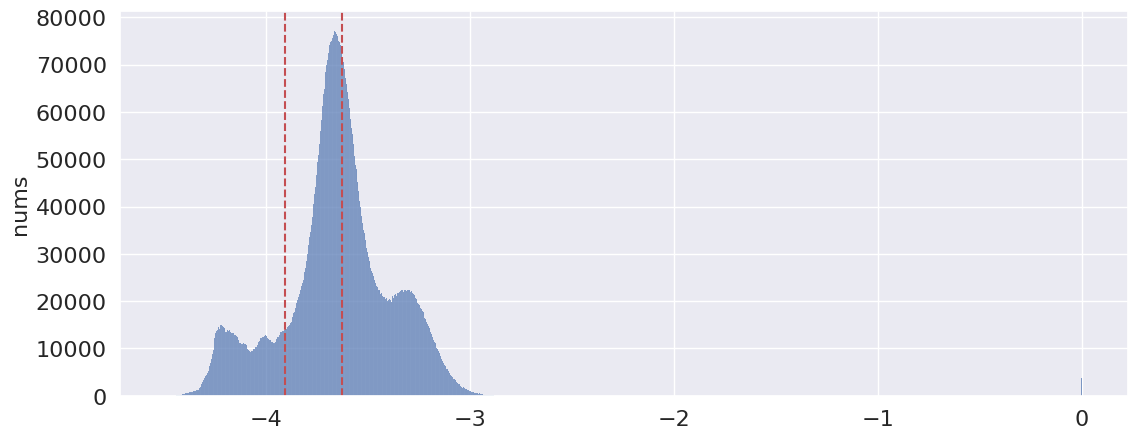

In [59]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()
plt.rcParams['figure.figsize'] = (13, 5)
f = plt.figure()

sns.histplot(sorted_series, kde=False)
plt.ylabel("nums", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("", fontsize=20)

# 指定特定数字
zero_value_num = zero_value
prune_value_num = prune_value

# 绘制竖线
plt.axvline(x=zero_value_num, color='r', linestyle='--')
plt.axvline(x=prune_value_num, color='r', linestyle='--')

plt.show()

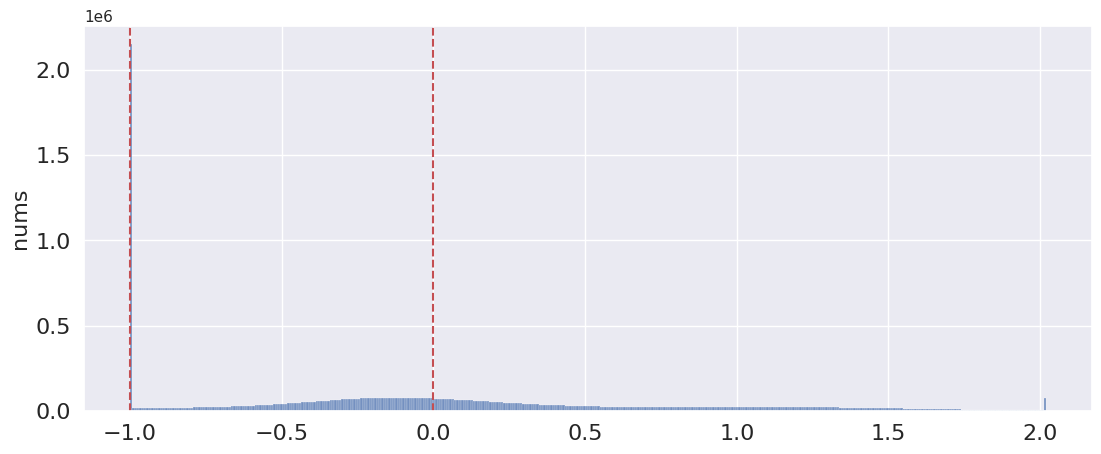

In [60]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()
plt.rcParams['figure.figsize'] = (13, 5)
f = plt.figure()

sns.histplot(distances_quantitive.select_dtypes(include=[np.number]).stack(), kde=False)
plt.ylabel("nums", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("", fontsize=20)

# 指定特定数字
zero_value_num = 0
prune_value_num = -1

# 绘制竖线
plt.axvline(x=zero_value_num, color='r', linestyle='--')
plt.axvline(x=prune_value_num, color='r', linestyle='--')

plt.show()

# 保存文件 df_euclidean_quantitive_x_x.csv

In [61]:
# distances_quantitive.to_csv('df_euclidean_quantitive_'+ str(myargs['cutoff'].value[0]) +'_'+ str(myargs['cutoff'].value[1]) +'.csv', encoding='utf-8') #6min

# 分块操作

In [62]:
# def get_type(x):
#     return x.split('-')[0]
# list(set(map(get_type, distances_quantitive.index)))
# print(myargs['ccc'].children)
for i in myargs['ccc'].children:
    if i.value == True:
        # print(i.description)
        t1 = i.description.split('-')[0]
        t2 = i.description.split('-')[1]
        # print(t1, t2)
        cut_row = []
        cut_col = []
        cut_row_name = {}
        cut_col_name = {}
        for jj,j in enumerate(distances_quantitive.index):
            if j.split('-')[0] == t1:
                cut_row.append(jj)
                cut_row_name[j] = j.split('-')[1]
        for kk,k in enumerate(distances_quantitive.columns):
            if k.split('-')[0] == t2:
                cut_col.append(kk)
                cut_row_name[k] = k.split('-')[1]
                
        df_tmp = distances_quantitive.iloc[cut_row,cut_col]
        df_tmp = df_tmp.rename(index = cut_row_name, columns = cut_row_name)
        df_tmp.to_csv(t1 + '_' + t2 + '_quantitive_' + str(myargs['cutoff'].value[0]) +'_'+ str(myargs['cutoff'].value[1]) +'.csv', encoding='utf-8') #6min


In [63]:
# import seaborn as sns
# import numpy as np
# import matplotlib.pyplot as plt

# sns.set()

# # x = np.random.randn(1000) 
# x = df_tmp.select_dtypes(include=[np.number]).stack()  # 一维化
# x
# plt.rcParams['figure.figsize'] = (13, 5)
# f = plt.figure()

# f.add_subplot(1, 2, 1)
# sns.histplot(x, kde=False)  # 使用histplot函数代替distplot函数
# plt.ylabel("nums", fontsize=16)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.title(t1+'_'+t2, fontsize=20)

# plt.show()

In [64]:
# dfsss = pd.read_csv('/home/ee_while/JOB240131/A1_G2_15.0_55.0.csv', na_values='NAN', header = 0, index_col = 0)
# row = dfsss.index.tolist()
# col = dfsss.columns.tolist()
# score_dict = {}
# for i in range(len(row)):
#     for j in range(len(col)):
#         score_dict[str(row[i])+ '_' + str(col[j])] = dfsss.values[i][j]
# score_dict

# 皮尔森定量计算

In [65]:
# 对dataframe所有元素排序
series_p = corr_coeffs.select_dtypes(include=[np.number]).stack()  # 一维化
sorted_series_p = series_p.sort_values()

zero_index_p = int(len(sorted_series_p) * myargs['cutoff'].value[1]/100)   # 0 标志位
prune_index_p = int(len(sorted_series_p) * myargs['cutoff'].value[0]/100)  # 剪枝标志位
zero_value_p = sorted_series_p.iloc[zero_index_p]
prune_value_p = sorted_series_p.iloc[prune_index_p]

noise_p = sorted_series_p.iloc[int(len(sorted_series_p) * 0.999)]

corr_coeffs_quantitive = corr_coeffs.applymap(lambda x: func(x, prune_value_p, zero_value_p, myargs['P'].children[0].value, noise_p))
corr_coeffs_quantitive

,A1-N99_1,A1-N997_1,A1-N460_1,A1-N723_1,A1-N316_1,A1-N134_1,A1-N906_1,A1-N357_1,A1-N426_1,A1-N271_1,...,GS-N1364_1,GS-N472_1,GS-N840_1,GS-N1327_1,GS-N1496_1,GS-N108_1,GS-N280_1,GS-N1465_1,GS-N1024_1,GS-N556_1
A1-N99_1,1.120984,-1.000000,0.465021,-0.141563,-0.284095,0.193711,-0.049573,-0.069254,0.089660,0.371360,...,-1.0,-0.327990,-0.940942,-0.458359,-0.501728,-0.468870,-0.497877,-0.515426,-0.292327,-0.415898
A1-N997_1,-1.000000,1.120984,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
A1-N460_1,0.465021,-1.000000,1.120984,0.290310,0.094544,0.571112,0.278098,0.402124,0.512697,0.887641,...,-1.0,0.043400,-0.619735,-0.092457,-0.142208,-0.099556,-0.132308,-0.147764,0.053354,-0.038726
A1-N723_1,-0.141563,-1.000000,0.290310,1.120984,-0.443763,-0.034456,-0.272917,-0.074435,-0.228336,0.222614,...,-1.0,-0.023878,-0.596661,-0.157646,-0.204603,-0.168346,-0.190604,-0.273503,0.007492,-0.156694
A1-N316_1,-0.284095,-1.000000,0.094544,-0.443763,1.120984,-0.181763,-0.538235,0.201963,-0.346523,0.069101,...,-1.0,-0.459666,-1.000000,-0.618418,-0.638817,-0.604765,-0.650165,-0.603171,-0.419241,-0.558790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GS-N108_1,-0.468870,-1.000000,-0.099556,-0.168346,-0.604765,-0.445230,-0.675546,-0.190095,-0.741996,-0.195782,...,-1.0,0.730158,0.134564,0.548234,0.556566,1.120984,0.552700,0.456594,0.710216,0.572325
GS-N280_1,-0.497877,-1.000000,-0.132308,-0.190604,-0.650165,-0.479045,-0.679268,-0.199980,-0.804078,-0.245233,...,-1.0,0.742187,0.169416,0.582592,0.538926,0.552700,1.120984,0.483021,0.768993,0.558983
GS-N1465_1,-0.515426,-1.000000,-0.147764,-0.273503,-0.603171,-0.518472,-0.722434,-0.255059,-0.797866,-0.260828,...,-1.0,0.646607,0.088019,0.513309,0.461791,0.456594,0.483021,1.120984,0.633729,0.486029
GS-N1024_1,-0.292327,-1.000000,0.053354,0.007492,-0.419241,-0.316950,-0.520538,-0.008391,-0.649751,-0.072104,...,-1.0,0.932304,0.336508,0.757793,0.702892,0.710216,0.768993,0.633729,1.120984,0.731285


# 保存文件 df_pearson_quantitive_x_x.csv

In [66]:
# corr_coeffs_quantitive.to_csv('df_pearson_quantitive_'+ str(myargs['cutoff'].value[0]) +'_'+ str(myargs['cutoff'].value[1]) +'.csv', encoding='utf-8') #6min

# 分块操作

In [67]:
for i in myargs['ccc'].children:
    if i.value == True:
        # print(i.description)
        t1 = i.description.split('-')[0]
        t2 = i.description.split('-')[1]
        # print(t1, t2)
    cut_row = []
    cut_col = []
    cut_row_name = {}
    cut_col_name = {}
    for jj,j in enumerate(distances_quantitive.index):
        if j.split('-')[0] == t1:
            cut_row.append(jj)
            cut_row_name[j] = j.split('-')[1]
    for kk,k in enumerate(distances_quantitive.columns):
        if k.split('-')[0] == t2:
            cut_col.append(kk)
            cut_row_name[k] = k.split('-')[1]

# #     # df_tmp = distances_quantitive.loc[cut_row, cut_row]
    df_tmp = distances_quantitive.iloc[cut_row,cut_col]
    df_tmp = df_tmp.rename(index = cut_row_name, columns = cut_row_name)
    df_tmp.to_csv(t1 + '_' + t2 + '_quantitive_pearson_' + str(myargs['cutoff'].value[0]) +'_'+ str(myargs['cutoff'].value[1]) +'.csv', encoding='utf-8') #6min
    

# 定性计算矩阵

In [68]:
distances_qualitative = distances_quantitive
distances_qualitative.index = df_celltype.index
distances_qualitative.columns = list(df_celltype.index)
get_cellpair_mean = {}

with tqdm(total=((1+distances_qualitative.shape[1])*distances_qualitative.shape[1])/2,desc='all_list') as pbar:
    for i in range(distances_qualitative.shape[1]):
        for j in range(i+1):
            if get_cellpair_mean.get(str(distances_qualitative.index[i]) + '_' + str(distances_qualitative.index[j])):
                get_cellpair_mean[str(distances_qualitative.index[i]) + '_' + str(distances_qualitative.index[j])].append(distances_qualitative.values[i][j])
            elif get_cellpair_mean.get(str(distances_qualitative.index[j]) + '_' + str(distances_qualitative.index[i])):
                get_cellpair_mean[str(distances_qualitative.index[j]) + '_' + str(distances_qualitative.index[i])].append(distances_qualitative.values[i][j])
            else:
                get_cellpair_mean[str(distances_qualitative.index[i]) + '_' + str(distances_qualitative.index[j])] = []
                get_cellpair_mean[str(distances_qualitative.index[i]) + '_' + str(distances_qualitative.index[j])].append(distances_qualitative.values[i][j])

            pbar.update()
# get_cellpair_mean
distances_qualitative = pd.DataFrame(columns=['CellType1', 'CellType2', 'Scores'])
for (k,v) in get_cellpair_mean.items():
    distances_qualitative.loc[k] = [k.split('_')[0], k.split('_')[1], sum(v)/len(v)]
distances_qualitative

all_list:   0%|          | 0/7119651.0 [00:00<?, ?it/s]

,CellType1,CellType2,Scores
C7_C7,C7,C7,0.360909
R1_C7,R1,C7,-0.848130
R1_R1,R1,R1,-0.877285
C10_C7,C10,C7,0.022372
C10_R1,C10,R1,-0.878980
...,...,...,...
C5_R2,C5,R2,-1.000000
C5_C2,C5,C2,-0.118432
C5_C1,C5,C1,-0.107952
C5_C3,C5,C3,-0.299277


# 保存文件 df_euclidean_qualitative_x_x.csv

In [69]:
distances_qualitative.to_csv('df_euclidean_qualitative_' + str(myargs['cutoff'].value[0]) +'_'+ str(myargs['cutoff'].value[1]) +'.csv', index=False)

# 皮尔森定性计算

In [70]:
corr_coeffs_qualitative = corr_coeffs_quantitive
corr_coeffs_qualitative.index = df_celltype.index
corr_coeffs_qualitative.columns = list(df_celltype.index)
get_cellpair_mean_pearson = {}

with tqdm(total=((1+corr_coeffs_qualitative.shape[1])*corr_coeffs_qualitative.shape[1])/2,desc='all_list') as pbar:
    for i in range(corr_coeffs_qualitative.shape[1]):
        for j in range(i+1):
            if get_cellpair_mean_pearson.get(str(corr_coeffs_qualitative.index[i]) + '_' + str(corr_coeffs_qualitative.index[j])):
                get_cellpair_mean_pearson[str(corr_coeffs_qualitative.index[i]) + '_' + str(corr_coeffs_qualitative.index[j])].append(corr_coeffs_qualitative.values[i][j])
            elif get_cellpair_mean_pearson.get(str(corr_coeffs_qualitative.index[j]) + '_' + str(corr_coeffs_qualitative.index[i])):
                get_cellpair_mean_pearson[str(corr_coeffs_qualitative.index[j]) + '_' + str(corr_coeffs_qualitative.index[i])].append(corr_coeffs_qualitative.values[i][j])
            else:
                get_cellpair_mean_pearson[str(corr_coeffs_qualitative.index[i]) + '_' + str(corr_coeffs_qualitative.index[j])] = []
                get_cellpair_mean_pearson[str(corr_coeffs_qualitative.index[i]) + '_' + str(corr_coeffs_qualitative.index[j])].append(corr_coeffs_qualitative.values[i][j])

            pbar.update()
# get_cellpair_mean_pearson
corr_coeffs_qualitative = pd.DataFrame(columns=['CellType1', 'CellType2', 'Scores'])
for (k,v) in get_cellpair_mean_pearson.items():
    corr_coeffs_qualitative.loc[k] = [k.split('_')[0], k.split('_')[1], sum(v)/len(v)]
corr_coeffs_qualitative

all_list:   0%|          | 0/7119651.0 [00:00<?, ?it/s]

,CellType1,CellType2,Scores
C7_C7,C7,C7,0.218457
R1_C7,R1,C7,-0.820958
R1_R1,R1,R1,-0.896970
C10_C7,C10,C7,-0.014271
C10_R1,C10,R1,-0.853324
...,...,...,...
C5_R2,C5,R2,-1.000000
C5_C2,C5,C2,-0.221702
C5_C1,C5,C1,-0.212373
C5_C3,C5,C3,-0.360924


# 保存文件 df_euclidean_qualitative.csv

In [71]:
corr_coeffs_qualitative.to_csv('df_pearson_qualitative_' + str(myargs['cutoff'].value[0]) +'_'+ str(myargs['cutoff'].value[1]) +'.csv', index=False)